In [109]:
import pandas as pd
import ast

In [317]:
# df = pd.read_csv('./data/bgg_stats_00001-10000.csv')
# df.head()

df1 = pd.read_csv('./data/bgg_stats_00001-10000.csv')
df2 = pd.read_csv('./data/bgg_stats_10001-20000.csv')
df3 = pd.read_csv('./data/bgg_stats_20001-30000.csv')
df4 = pd.read_csv('./data/bgg_stats_30001-40000.csv')
df5 = pd.read_csv('./data/bgg_stats_40001-50000.csv')
df6 = pd.read_csv('./data/bgg_stats_50001-60000.csv')
df7 = pd.read_csv('./data/bgg_stats_60001-70000.csv')
df8 = pd.read_csv('./data/bgg_stats_70001-80000.csv')
df9 = pd.read_csv('./data/bgg_stats_80001-90000.csv')
df10 = pd.read_csv('./data/bgg_stats_90001-100000.csv')
df11_20 = [
    pd.read_csv('./data/bgg_stats_100001-110000.csv'),
    pd.read_csv('./data/bgg_stats_110001-120000.csv'),
    pd.read_csv('./data/bgg_stats_120001-130000.csv'),
    pd.read_csv('./data/bgg_stats_130001-140000.csv'),
    pd.read_csv('./data/bgg_stats_140001-150000.csv'),
    pd.read_csv('./data/bgg_stats_150001-160000.csv'),
    pd.read_csv('./data/bgg_stats_160001-170000.csv'),
    pd.read_csv('./data/bgg_stats_170001-180000.csv'),
    pd.read_csv('./data/bgg_stats_180001-190000.csv'),
    pd.read_csv('./data/bgg_stats_190001-200000.csv')
]
df11_20 = pd.concat(df11_20)
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11_20])
len(df)


180678

In [318]:
del df['thumbnail']
del df['image']

In [319]:
# Function to parse cells containing strings that look like: "{'@value': '1986'}"
def parse_value(cell):
    try:
        new_val = ast.literal_eval(cell)
        new_val = new_val['@value']
        new_val = int(new_val)
    except:
        new_val = None
    return new_val

# Function to parse the name -- can be a dict or list of dicts
def parse_name(cell):
    name = ast.literal_eval(cell)
    if type(name) is list:
        name = name[0]
    return name['@value']

In [323]:
df2 = df.copy()
cols = ['yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage']
df2 = df2.dropna(subset=cols)
df2 = df2.dropna(subset=['link'])
for col in cols:
    df2[col] = df2[col].apply(parse_value)
df2['name'] = df2['name'].apply(parse_name)
len(df2)


83400

In [324]:
# Extracts the board game categories from the raw format of the "link" field.
# Returns a list of dicts with "id" and "value" keys:
#     [{'id': '1021', 'value': 'Economic'},
#     {'id': '1026', 'value': 'Negotiation'},
#     {'id': '1001', 'value': 'Political'}]
def get_categories(link):
    link_list = ast.literal_eval(link)
    if isinstance(link_list, dict):
        if link_list['@type'] == 'boardgamecategory':
            return [{
                'id': link_list['@id'],
                'value': link_list['@value']
            }]
        return None
    if isinstance(link_list, list):
        filtered = list(
            filter(lambda x: x['@type'] == 'boardgamecategory',
            link_list
        ))
        return list(map(lambda x: {'id': x['@id'], 'value': x['@value']}, filtered))
    return None

df2['categories'] = df2['link'].apply(get_categories)
df2.head()


,@type,@id,name,description,yearpublished,minplayers,maxplayers,poll,playingtime,minplaytime,maxplaytime,minage,link,statistics,marketplacelistings,releasedate,seriescode,datepublished,issueindex,categories
0,boardgame,1,Die Macher,Die Macher is a game about seven sequential po...,1986,3,5,"[{'@name': 'suggested_numplayers', '@title': '...",240,240,240,14,"[{'@type': 'boardgamecategory', '@id': '1021',...","{'@page': '1', 'ratings': {'usersrated': {'@va...","{'listing': [{'listdate': {'@value': 'Wed, 18 ...",NaN,NaN,NaN,NaN,"[{'id': '1021', 'value': 'Economic'}, {'id': '..."
1,boardgame,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,3,4,"[{'@name': 'suggested_numplayers', '@title': '...",30,30,30,12,"[{'@type': 'boardgamecategory', '@id': '1002',...","{'@page': '1', 'ratings': {'usersrated': {'@va...","{'listing': {'listdate': {'@value': 'Wed, 27 D...",NaN,NaN,NaN,NaN,"[{'id': '1002', 'value': 'Card Game'}, {'id': ..."
2,boardgame,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,2,4,"[{'@name': 'suggested_numplayers', '@title': '...",60,30,60,10,"[{'@type': 'boardgamecategory', '@id': '1009',...","{'@page': '1', 'ratings': {'usersrated': {'@va...","{'listing': [{'listdate': {'@value': 'Wed, 10 ...",NaN,NaN,NaN,NaN,"[{'id': '1009', 'value': 'Abstract Strategy'},..."
3,boardgame,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,2,4,"[{'@name': 'suggested_numplayers', '@title': '...",60,60,60,12,"[{'@type': 'boardgamecategory', '@id': '1050',...","{'@page': '1', 'ratings': {'usersrated': {'@va...","{'listing': [{'listdate': {'@value': 'Tue, 26 ...",NaN,NaN,NaN,NaN,"[{'id': '1050', 'value': 'Ancient'}]"
4,boardgame,5,Acquire,"In Acquire, each player strategically invests ...",1963,2,6,"[{'@name': 'suggested_numplayers', '@title': '...",90,90,90,12,"[{'@type': 'boardgamecategory', '@id': '1021',...","{'@page': '1', 'ratings': {'usersrated': {'@va...","{'listing': [{'listdate': {'@value': 'Thu, 21 ...",NaN,NaN,NaN,NaN,"[{'id': '1021', 'value': 'Economic'}, {'id': '..."


In [325]:
# Extracts the board game mechanics from the raw format of the "link" field.
# Returns a list of dicts with "id" and "value" keys
def get_mechanics(link):
    link_list = ast.literal_eval(link)
    if isinstance(link_list, dict):
        if link_list['@type'] == 'boardgamemechanic':
            return [{
                'id': link_list['@id'],
                'value': link_list['@value']
            }]
        return None
    filtered = list(
        filter(lambda x: x['@type'] == 'boardgamemechanic',
        link_list
    ))
    return list(map(lambda x: {'id': x['@id'], 'value': x['@value']}, filtered))

df2['mechanics'] = df2['link'].apply(get_mechanics)
len(df2)

83400

In [326]:
# Extracts the values from a list of id/value dicts
def id_val_to_strings(l):
    return list(map(lambda x: x['value'], l))

df3 = df2[['name', 'yearpublished', 'categories', 'mechanics']].copy()
df3.columns = ['name', 'year', 'categories', 'mechanics']
df3.dropna(inplace=True)
df3['categories'] = df3['categories'].apply(id_val_to_strings)
df3['mechanics'] = df3['mechanics'].apply(id_val_to_strings)

cats_by_year = df3[['year', 'categories']].copy().dropna()
cats_by_year = cats_by_year.astype({'year': int})
cats_by_year = cats_by_year.explode('categories').reset_index(drop=True)
# cats_by_year.head()

# Group similar categories
cats_by_year.replace(to_replace=r'^.*War.*$', value='War', regex=True, inplace=True)
cats_by_year.replace(to_replace='Economic', value='Economy / Industry', inplace=True)
cats_by_year.replace(to_replace='Farming', value='Economy / Industry', inplace=True)
cats_by_year.replace(to_replace='Industry / Manufacturing', value='Economy / Industry', inplace=True)
cats_by_year.replace(to_replace='Bluffing', value='Bluffing / Negotiation', inplace=True)
cats_by_year.replace(to_replace='Negotiation', value='Bluffing / Negotiation', inplace=True)

# display(cats_by_year.head())

piv = cats_by_year.pivot_table(index='year', columns='categories', aggfunc=lambda x: 1, fill_value=0)
# display(piv.loc[piv.index > 1900])
piv = piv.loc[piv.index > 1900].copy()
# display(piv.tail())
piv = piv.groupby('year').sum()
del piv['Collectible Components']
del piv['Expansion for Base-game']
del piv['Game System']
del piv['Video Game Theme']
len(piv)

# piv[['Action / Dexterity', 'Bluffing / Negotiation', 'City Building', 'Deduction',
#     'Economy / Industry', 'Exploration',
#     'Math', 'Music', 'Number', 'Party Game',
#     'Puzzle', 'Territory Building', 'War']].plot()

# counts = cats_by_year[['categories']]
# counts


125

,val
categories,
War,20697
Card Game,18729
Children's Game,11064
Expansion for Base-game,10001
Fantasy,7138
Dice,7127
Abstract Strategy,7050
Economy / Industry,6596
Educational,6384


<Axes: xlabel='year'>

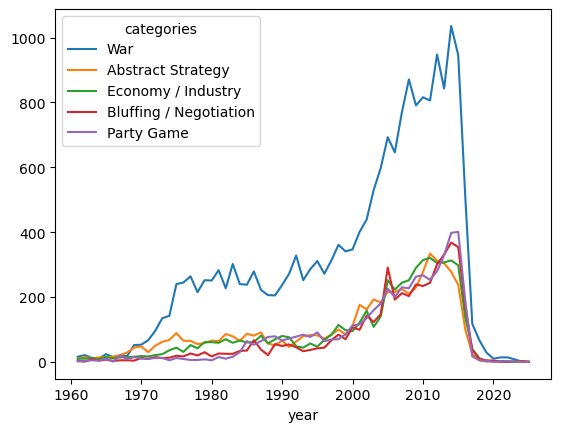

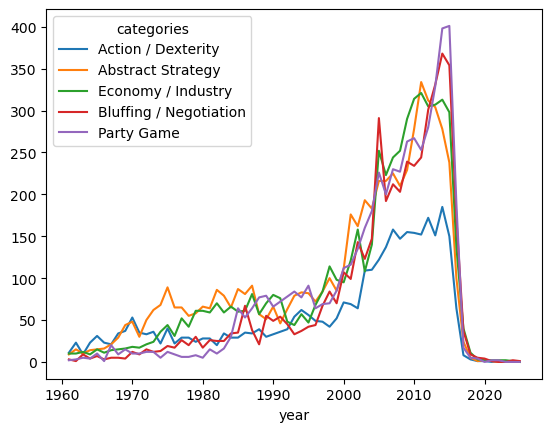

In [327]:
counts = cats_by_year[['categories']]
counts['val'] = 1
counts = counts.groupby('categories').sum()
display(counts.sort_values('val', ascending=False).head(20))

cats_by_year.columns
cby = cats_by_year.copy()
cby['val'] = 1
piv2 = cby.pivot_table(index='year', columns='categories', values='val', aggfunc='sum', fill_value=0)
piv2 = piv2.loc[piv2.index > 1960].copy()
piv2[['War', 'Abstract Strategy', 'Economy / Industry', 'Bluffing / Negotiation', 'Party Game']].plot()
piv2[['Action / Dexterity', 'Abstract Strategy', 'Economy / Industry', 'Bluffing / Negotiation', 'Party Game']].plot()